# XGBoost - Models evaluation & tresholds

## Imports & Configuration

In [42]:
from Evaluator import Evaluator
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import pickle

In [2]:
valid = pd.read_csv(r'C:\Users\Antoine\Coding Bootcamp\Open Food Facts\Notebooks\Model Selection & Parameters\valid_dataset.csv')
test = pd.read_csv(r'C:\Users\Antoine\Coding Bootcamp\Open Food Facts\Notebooks\Model Selection & Parameters\test_dataset.csv')
X_test = test.drop(columns=['y_test_g1', 'y_test_g2'])
y_test_G1 = test['y_test_g1']
y_test_G2 = test['y_test_g2']
X_valid = valid.drop(columns=['y_val_g1', 'y_val_g2'])
y_valid_G1 = valid['y_val_g1']
y_valid_G2 = valid['y_val_g2']
X_test.shape, y_test_G1.shape, y_test_G2.shape, X_valid.shape, y_valid_G1.shape, y_valid_G2.shape

((25133, 938), (25133,), (25133,), (28483, 938), (28483,), (28483,))

In [12]:
def get_confidences(y_pred, y_probas, unk_code=9):
    """ Get confidence -range (0,1)- for the label predicted"""
    probas = []
    for index, label in enumerate(y_pred):
        if label < unk_code : 
            probas.append(y_probas[index,label])
        else : probas.append(0.0)
    confidences = np.array(probas).reshape(-1,1)
    return confidences

# $XGBoostG_1$

In [59]:
model_G1 = XGBClassifier()
model_G1.load_model(r'C:\Users\Antoine\Coding Bootcamp\Open Food Facts\Notebooks\Model Selection & Parameters\xgboost_G1_m2.model')
pkl_file_G1 = open(r'C:\Users\Antoine\Coding Bootcamp\Open Food Facts\Notebooks\Model Evaluation\label_encoder_g1.pkl', 'rb')
le_G1 = pickle.load(pkl_file_G1)
pkl_file_G1.close()

In [60]:
y_pred_G1 = model_G1.predict(X_valid)
y_proba_G1 = model_G1.predict_proba(X_valid)
y_conf_G1 = get_confidences(y_pred_G1, y_proba_G1)

## $Evaluation$ $Valid set$ - $XGBoostG_1$

In [68]:
eval_G1 = Evaluator()
eval_G1.build_data(y_pred=y_pred_G1, y_true=y_valid_G1, y_confidence=y_conf_G1, decode_labels=True, label_encoder=le_G1)

y_true                   y_pred  pred_is_true  \
0      milk and dairy products  milk and dairy products             1   
1                    beverages            sugary snacks             0   
2               fish meat eggs           fish meat eggs             1   
3              composite foods  milk and dairy products             0   
4               fish meat eggs           fish meat eggs             1   
...                        ...                      ...           ...   
28478    fruits and vegetables    fruits and vegetables             1   
28479            sugary snacks            sugary snacks             1   
28480  milk and dairy products  milk and dairy products             1   
28481                beverages                beverages             1   
28482    fruits and vegetables    fruits and vegetables             1   

       pred_confidence  
0             0.945825  
1             0.872838  
2             0.889920  
3             0.294058  
4             0.995574  
...                ...  
28478         0.965806  
28479         0.966708  
28480         0.918462  
28481         0.905064  
28482         0.403875  

[28483 rows x 4 columns]

In [69]:
eval_G1.classification_report()

model_precision  model_recall  model_f1-score  \
milk and dairy products             0.94          0.90            0.92   
sugary snacks                       0.92          0.93            0.92   
fat and sauces                      0.91          0.87            0.89   
fish meat eggs                      0.89          0.88            0.89   
salty snacks                        0.89          0.81            0.85   
weighted avg                        0.87          0.87            0.87   
accuracy                            0.87          0.87            0.87   
macro avg                           0.87          0.86            0.86   
cereals and potatoes                0.86          0.82            0.84   
composite foods                     0.81          0.79            0.80   
fruits and vegetables               0.80          0.76            0.78   
beverages                           0.77          0.93            0.84   

                         model_support  
milk and dairy products        3761.00  
sugary snacks                  6157.00  
fat and sauces                 1772.00  
fish meat eggs                 3449.00  
salty snacks                   1764.00  
weighted avg                  28483.00  
accuracy                          0.87  
macro avg                     28483.00  
cereals and potatoes           2955.00  
composite foods                2943.00  
fruits and vegetables          2399.00  
beverages                      3283.00

In [70]:
eval_G1.global_metrics()

Model Classification Metrics :
------------------------------
Accuracy : 86.93%
Recall : 86.93%
Precision : 87.16%
F1-score : 86.92%




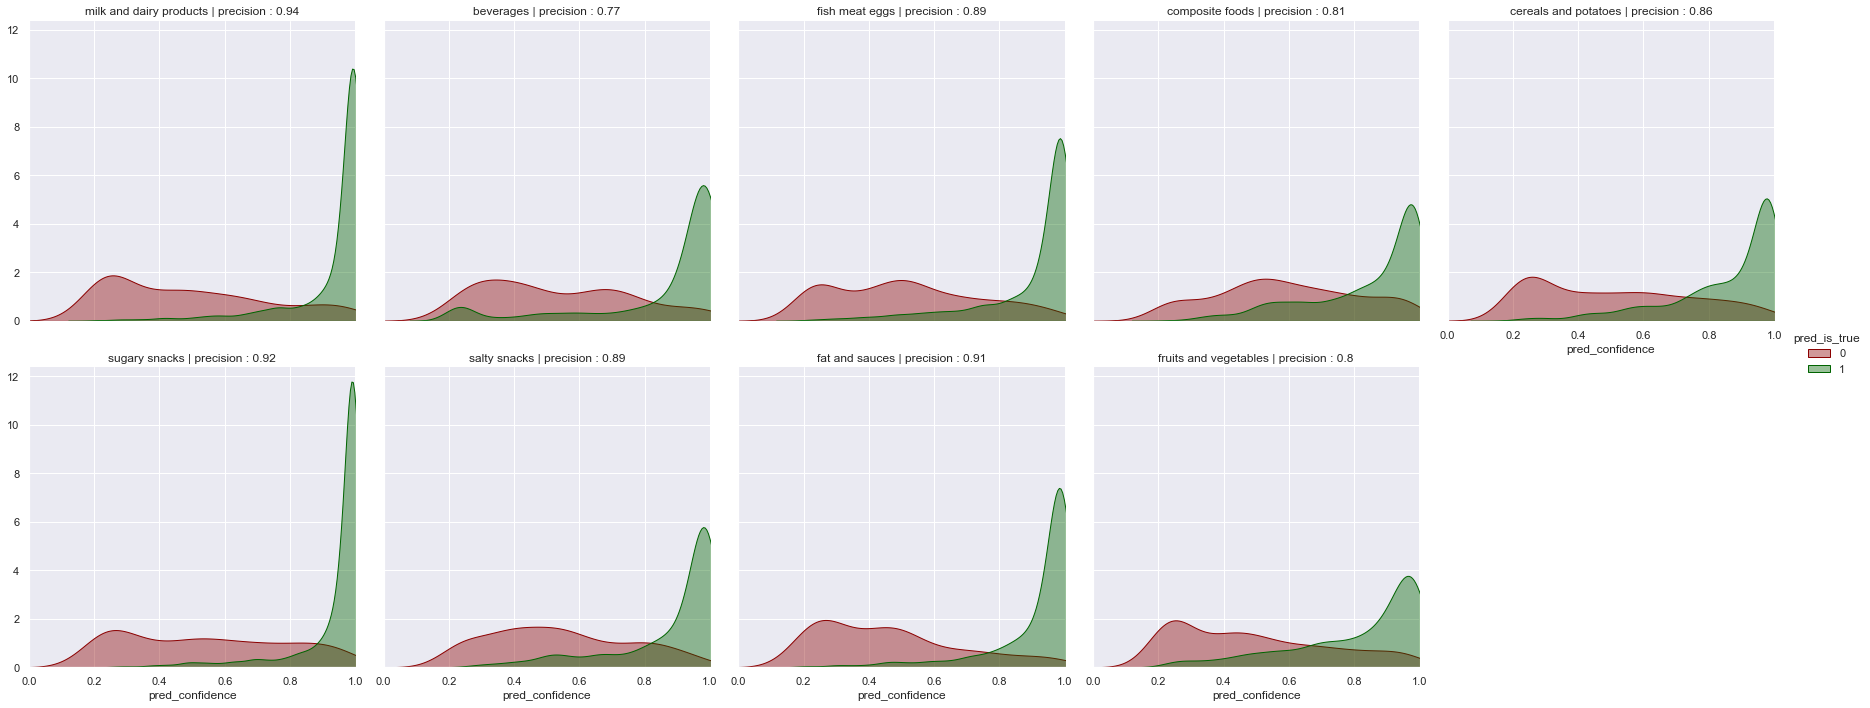

In [71]:
eval_G1.plot_confidence()

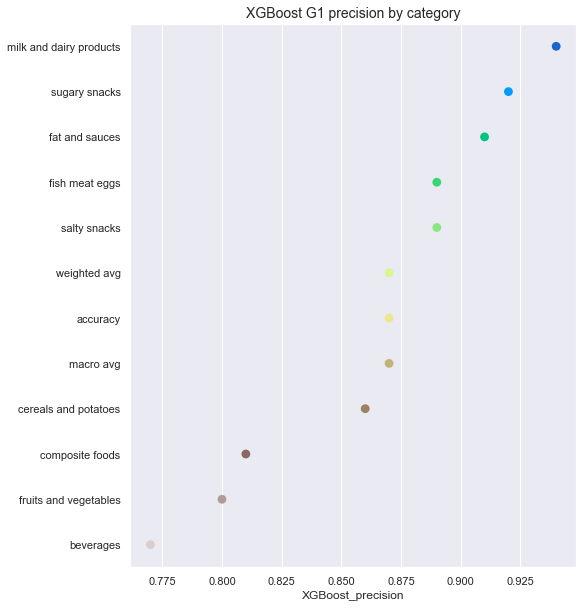

In [73]:
eval_G1.plot_categories_scores(name=r'XGBoost')

## $Tresholds$ - $XGBoostG_1$

In [96]:
def filter_preds(y_true, y_probas, tresholds):
    preds = []
    for p in y_probas:
        result = np.argwhere(p > tresholds)
        if result.size > 0: preds.append(int(result[0]))
        else : preds.append(9)
        indices = np.array(np.where(np.array(preds) < 9)).flatten()
        y_true_keep = np.array(np.take(y_true, indices)).flatten()
        y_preds = np.take(np.array(preds), indices).flatten()
        return y_true_keep, y_preds

In [97]:
tresh_G1 = np.full(shape=9, fill_value=0.5, dtype=float)
y_true_keep, y_pred_keep = filter_preds(y_valid_G1, y_proba_G1, tresh_G1)

In [106]:
eval_G1_tresh = Evaluator()
eval_G1_tresh.build_data(y_true=y_true_keep, y_pred=y_pred_keep, decode_labels=True, label_encoder=le_G1, pred_type='G1')

y_true                   y_pred  pred_is_true
0      milk and dairy products  milk and dairy products             1
1                    beverages            sugary snacks             0
2               fish meat eggs           fish meat eggs             1
3               fish meat eggs           fish meat eggs             1
4         cereals and potatoes     cereals and potatoes             1
...                        ...                      ...           ...
25386          composite foods          composite foods             1
25387    fruits and vegetables    fruits and vegetables             1
25388            sugary snacks            sugary snacks             1
25389  milk and dairy products  milk and dairy products             1
25390                beverages                beverages             1

[25391 rows x 3 columns]

In [103]:
eval_G1_tresh.classification_report()

model_precision  model_recall  model_f1-score  \
milk and dairy products             0.96          0.95            0.96   
fat and sauces                      0.95          0.95            0.95   
sugary snacks                       0.94          0.96            0.95   
salty snacks                        0.94          0.88            0.91   
beverages                           0.94          0.96            0.95   
fish meat eggs                      0.93          0.94            0.93   
accuracy                            0.93          0.93            0.93   
weighted avg                        0.93          0.93            0.93   
macro avg                           0.92          0.92            0.92   
cereals and potatoes                0.90          0.90            0.90   
fruits and vegetables               0.89          0.87            0.88   
composite foods                     0.85          0.84            0.85   

                         model_support  
milk and dairy products        3469.00  
fat and sauces                 1569.00  
sugary snacks                  5828.00  
salty snacks                   1534.00  
beverages                      2839.00  
fish meat eggs                 3121.00  
accuracy                          0.93  
weighted avg                  25391.00  
macro avg                     25391.00  
cereals and potatoes           2552.00  
fruits and vegetables          1882.00  
composite foods                2597.00

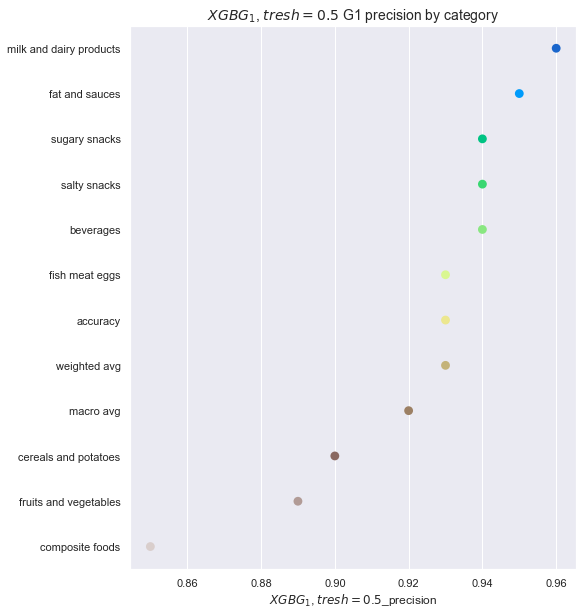

In [108]:
eval_G1_tresh.plot_categories_scores(name=r'$XGB$$G_1$, $tresh=0.5$')

## $Evaluation$ $Test set$ - $XGBoostG_1$ - $without$ $tresholds$

In [109]:
test_pred_G1_full = model_G1.predict(X_test)
test_proba_G1 = model_G1.predict_proba(X_test)
test_conf_G1 = get_confidences(test_pred_G1_full, test_proba_G1)

In [113]:
eval_G1_test = Evaluator()
eval_G1_test.build_data(y_true=y_test_G1, y_pred=test_pred_G1_full, y_confidence=test_conf_G1, decode_labels=True, label_encoder=le_G1, pred_type='G1')

y_true                   y_pred  pred_is_true  \
0                sugary snacks            sugary snacks             1   
1                    beverages                beverages             1   
2        fruits and vegetables                beverages             0   
3              composite foods          composite foods             1   
4      milk and dairy products  milk and dairy products             1   
...                        ...                      ...           ...   
25128             salty snacks             salty snacks             1   
25129           fish meat eggs           fish meat eggs             1   
25130  milk and dairy products  milk and dairy products             1   
25131    fruits and vegetables          composite foods             0   
25132          composite foods          composite foods             1   

       pred_confidence  
0             0.989237  
1             0.869753  
2             0.596412  
3             0.965520  
4             0.913225  
...                ...  
25128         0.880653  
25129         0.940903  
25130         0.991969  
25131         0.849061  
25132         0.964341  

[25133 rows x 4 columns]

In [114]:
eval_G1_test.classification_report(name='XGB_G1_Test')

XGB_G1_Test_precision  XGB_G1_Test_recall  \
milk and dairy products                   0.93                0.90   
sugary snacks                             0.92                0.93   
fat and sauces                            0.91                0.86   
fish meat eggs                            0.90                0.88   
weighted avg                              0.87                0.87   
accuracy                                  0.87                0.87   
macro avg                                 0.86                0.85   
salty snacks                              0.86                0.79   
cereals and potatoes                      0.85                0.82   
composite foods                           0.80                0.79   
fruits and vegetables                     0.80                0.76   
beverages                                 0.78                0.92   

                         XGB_G1_Test_f1-score  XGB_G1_Test_support  
milk and dairy products                  0.91              3319.00  
sugary snacks                            0.92              5433.00  
fat and sauces                           0.88              1564.00  
fish meat eggs                           0.89              3043.00  
weighted avg                             0.87             25133.00  
accuracy                                 0.87                 0.87  
macro avg                                0.85             25133.00  
salty snacks                             0.82              1557.00  
cereals and potatoes                     0.84              2607.00  
composite foods                          0.80              2596.00  
fruits and vegetables                    0.78              2117.00  
beverages                                0.84              2897.00

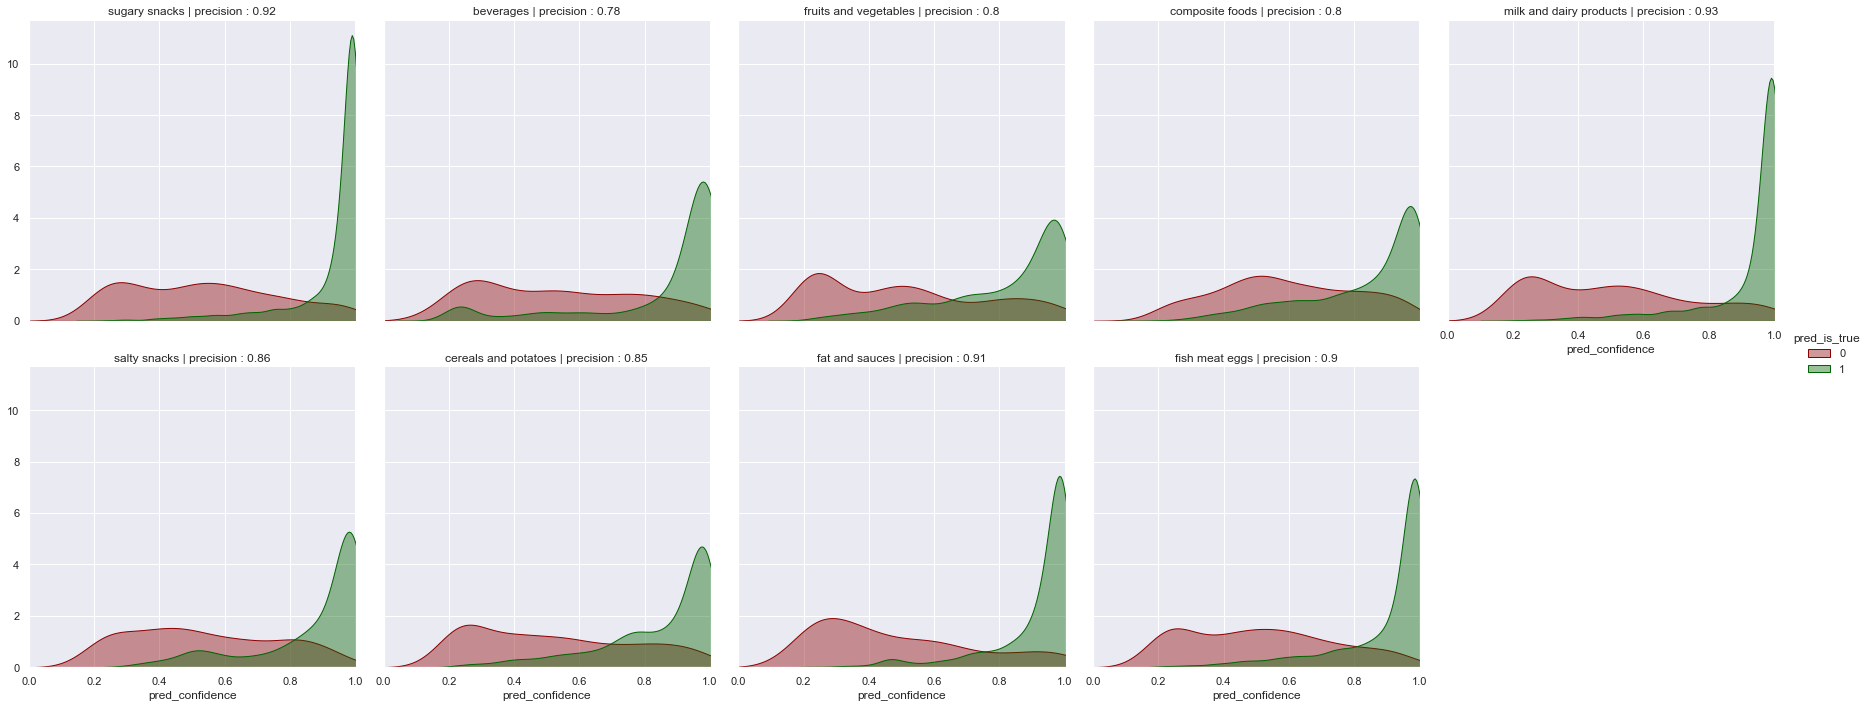

In [115]:
eval_G1_test.plot_confidence()

## $Evaluation$ $Testset$ - $XGBoostG_1$ - $tresh=0.5$

In [116]:
tresh_G1 = np.full(shape=9, fill_value=0.5, dtype=float)
test_true_G1, test_pred_G1 = filter_preds(y_test_G1, test_proba_G1, tresh_G1)
tresh_G1_test = Evaluator()
tresh_G1_test.build_data(y_true=test_true_G1, y_pred=test_pred_G1, decode_labels=True,label_encoder=le_G1, pred_type='G1')

y_true                   y_pred  pred_is_true
0                sugary snacks            sugary snacks             1
1                    beverages                beverages             1
2        fruits and vegetables                beverages             0
3              composite foods          composite foods             1
4      milk and dairy products  milk and dairy products             1
...                        ...                      ...           ...
22318             salty snacks             salty snacks             1
22319           fish meat eggs           fish meat eggs             1
22320  milk and dairy products  milk and dairy products             1
22321    fruits and vegetables          composite foods             0
22322          composite foods          composite foods             1

[22323 rows x 3 columns]

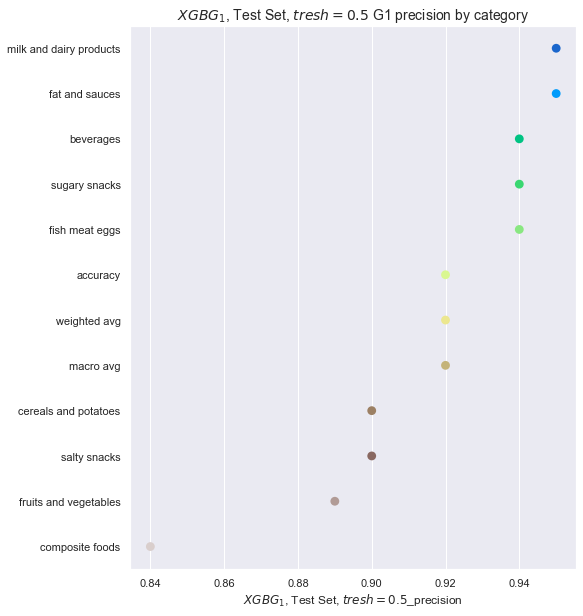

In [117]:
tresh_G1_test.plot_categories_scores(name=r'$XGB$$G_1$, Test Set, $tresh=0.5$')

# $XGBoostG_2$

In [119]:
def filter_preds_keep(y_true, y_probas, tresholds):
  preds = []
  for p in y_probas:
    result = np.argwhere(p > tresholds)
    if result.size > 0: preds.append(int(result[0]))
    else : preds.append(9)
  return preds

In [120]:
preds_G1_filt_valid = filter_preds_keep(y_true=y_valid_G1, y_probas=y_proba_G1, tresholds=tresh_G1)
preds_G1_filt_test = filter_preds_keep(y_true=y_test_G1, y_probas=test_proba_G1, tresholds=tresh_G1)

In [ ]:
y_test_G1 = test['y_test_g1']
y_test_G2 = test['y_test_g2'
y_valid_G1 = valid['y_val_g1']
y_valid_G2 = valid['y_val_g2']

In [118]:
model_G2 = XGBClassifier()
model_G2.load_model(r'C:\Users\Antoine\Coding Bootcamp\Open Food Facts\Notebooks\Model Selection & Parameters\xgboost_G2_m1.model')
pkl_file_G2 = open(r'C:\Users\Antoine\Coding Bootcamp\Open Food Facts\Notebooks\Model Evaluation\label_encoder_g2.pkl', 'rb')
le_G2 = pickle.load(pkl_file_G2)
pkl_file_G2.close()

In [121]:
X_test_G2 = X_test.copy(deep=True)
X_valid_G2 = X_valid.copy(deep=True)
X_test_G2['pred_g1'] = preds_G1_filt_test
X_valid_G2['pred_g1'] = preds_G1_filt_valid

## $Evaluation$ $Valid set$ - $XGBoostG_2$

In [122]:
y_preds_G2_valid = model_G2.predict(X_valid_G2)
y_proba_G2_valid = model_G2.predict_proba(X_valid_G2)

In [125]:
y_conf_G2_valid = get_confidences(y_preds_G2_valid, y_proba_G2_valid, unk_code=38)

In [124]:
y_proba_G2_valid.shape

(28483, 38)

In [126]:
eval_G2_valid = Evaluator()
eval_G2_valid.build_data(y_pred=y_preds_G2_valid, y_true=y_valid_G2, y_confidence=y_conf_G2_valid, decode_labels=True, label_encoder=le_G2)

y_true                      y_pred  pred_is_true  \
0           dairy desserts              dairy desserts             1   
1      sweetened beverages          chocolate products             0   
2         fish and seafood            fish and seafood             1   
3           one dish meals              one dish meals             1   
4           processed meat              processed meat             1   
...                    ...                         ...           ...   
28478           vegetables                  vegetables             1   
28479               sweets                      sweets             1   
28480      milk and yogurt             milk and yogurt             1   
28481  sweetened beverages         sweetened beverages             1   
28482           vegetables  waters and flavored waters             0   

       pred_confidence  
0             0.810219  
1             0.670033  
2             0.949083  
3             0.177712  
4             0.926521  
...                ...  
28478         0.981238  
28479         0.990416  
28480         0.935246  
28481         0.950647  
28482         0.145960  

[28483 rows x 4 columns]

In [127]:
eval_G2_valid.global_metrics()

Model Classification Metrics :
------------------------------
Accuracy : 80.89%
Recall : 80.89%
Precision : 81.63%
F1-score : 81.03%




In [128]:
eval_G2_valid.classification_report()

model_precision  model_recall  \
pizza pies and quiche                        0.93          0.85   
cheese                                       0.91          0.89   
sandwiches                                   0.91          0.76   
salty and fatty products                     0.90          0.84   
eggs                                         0.90          0.86   
pastries                                     0.89          0.73   
dressings and sauces                         0.89          0.88   
fats                                         0.89          0.85   
offals                                       0.89          0.58   
processed meat                               0.88          0.92   
breakfast cereals                            0.88          0.82   
sweets                                       0.88          0.86   
ice cream                                    0.87          0.83   
potatoes                                     0.87          0.81   
milk and yogurt                              0.86          0.89   
fish and seafood                             0.86          0.82   
appetizers                                   0.86          0.76   
chocolate products                           0.86          0.89   
biscuits and cakes                           0.85          0.88   
plant based milk substitutes                 0.85          0.82   
dairy desserts                               0.85          0.68   
nuts                                         0.85          0.75   
bread                                        0.85          0.80   
weighted avg                                 0.82          0.81   
cereals                                      0.81          0.79   
dried fruits                                 0.81          0.62   
sweetened beverages                          0.81          0.85   
accuracy                                     0.81          0.81   
macro avg                                    0.81          0.77   
fruits                                       0.80          0.75   
fruit juices                                 0.79          0.88   
soups                                        0.79          0.73   
meat                                         0.76          0.69   
one dish meals                               0.73          0.77   
legumes                                      0.72          0.70   
artificially sweetened beverages             0.71          0.66   
waters and flavored waters                   0.65          0.70   
fruit nectars                                0.63          0.44   
teas and herbal teas and coffees             0.55          0.56   
vegetables                                   0.52          0.79   
unsweetened beverages                        0.42          0.40   

                                  model_f1-score  model_support  
pizza pies and quiche                       0.89         291.00  
cheese                                      0.90        1404.00  
sandwiches                                  0.83         222.00  
salty and fatty products                    0.87         837.00  
eggs                                        0.88         129.00  
pastries                                    0.80         313.00  
dressings and sauces                        0.89        1164.00  
fats                                        0.87         608.00  
offals                                      0.70          83.00  
processed meat                              0.90        1437.00  
breakfast cereals                           0.85         473.00  
sweets                                      0.87        2340.00  
ice cream                                   0.85         414.00  
potatoes                                    0.84         200.00  
milk and yogurt                             0.88        1231.00  
fish and seafood                            0.84         942.00  
appetizers                                  0.81         672.00  
chocolate products             

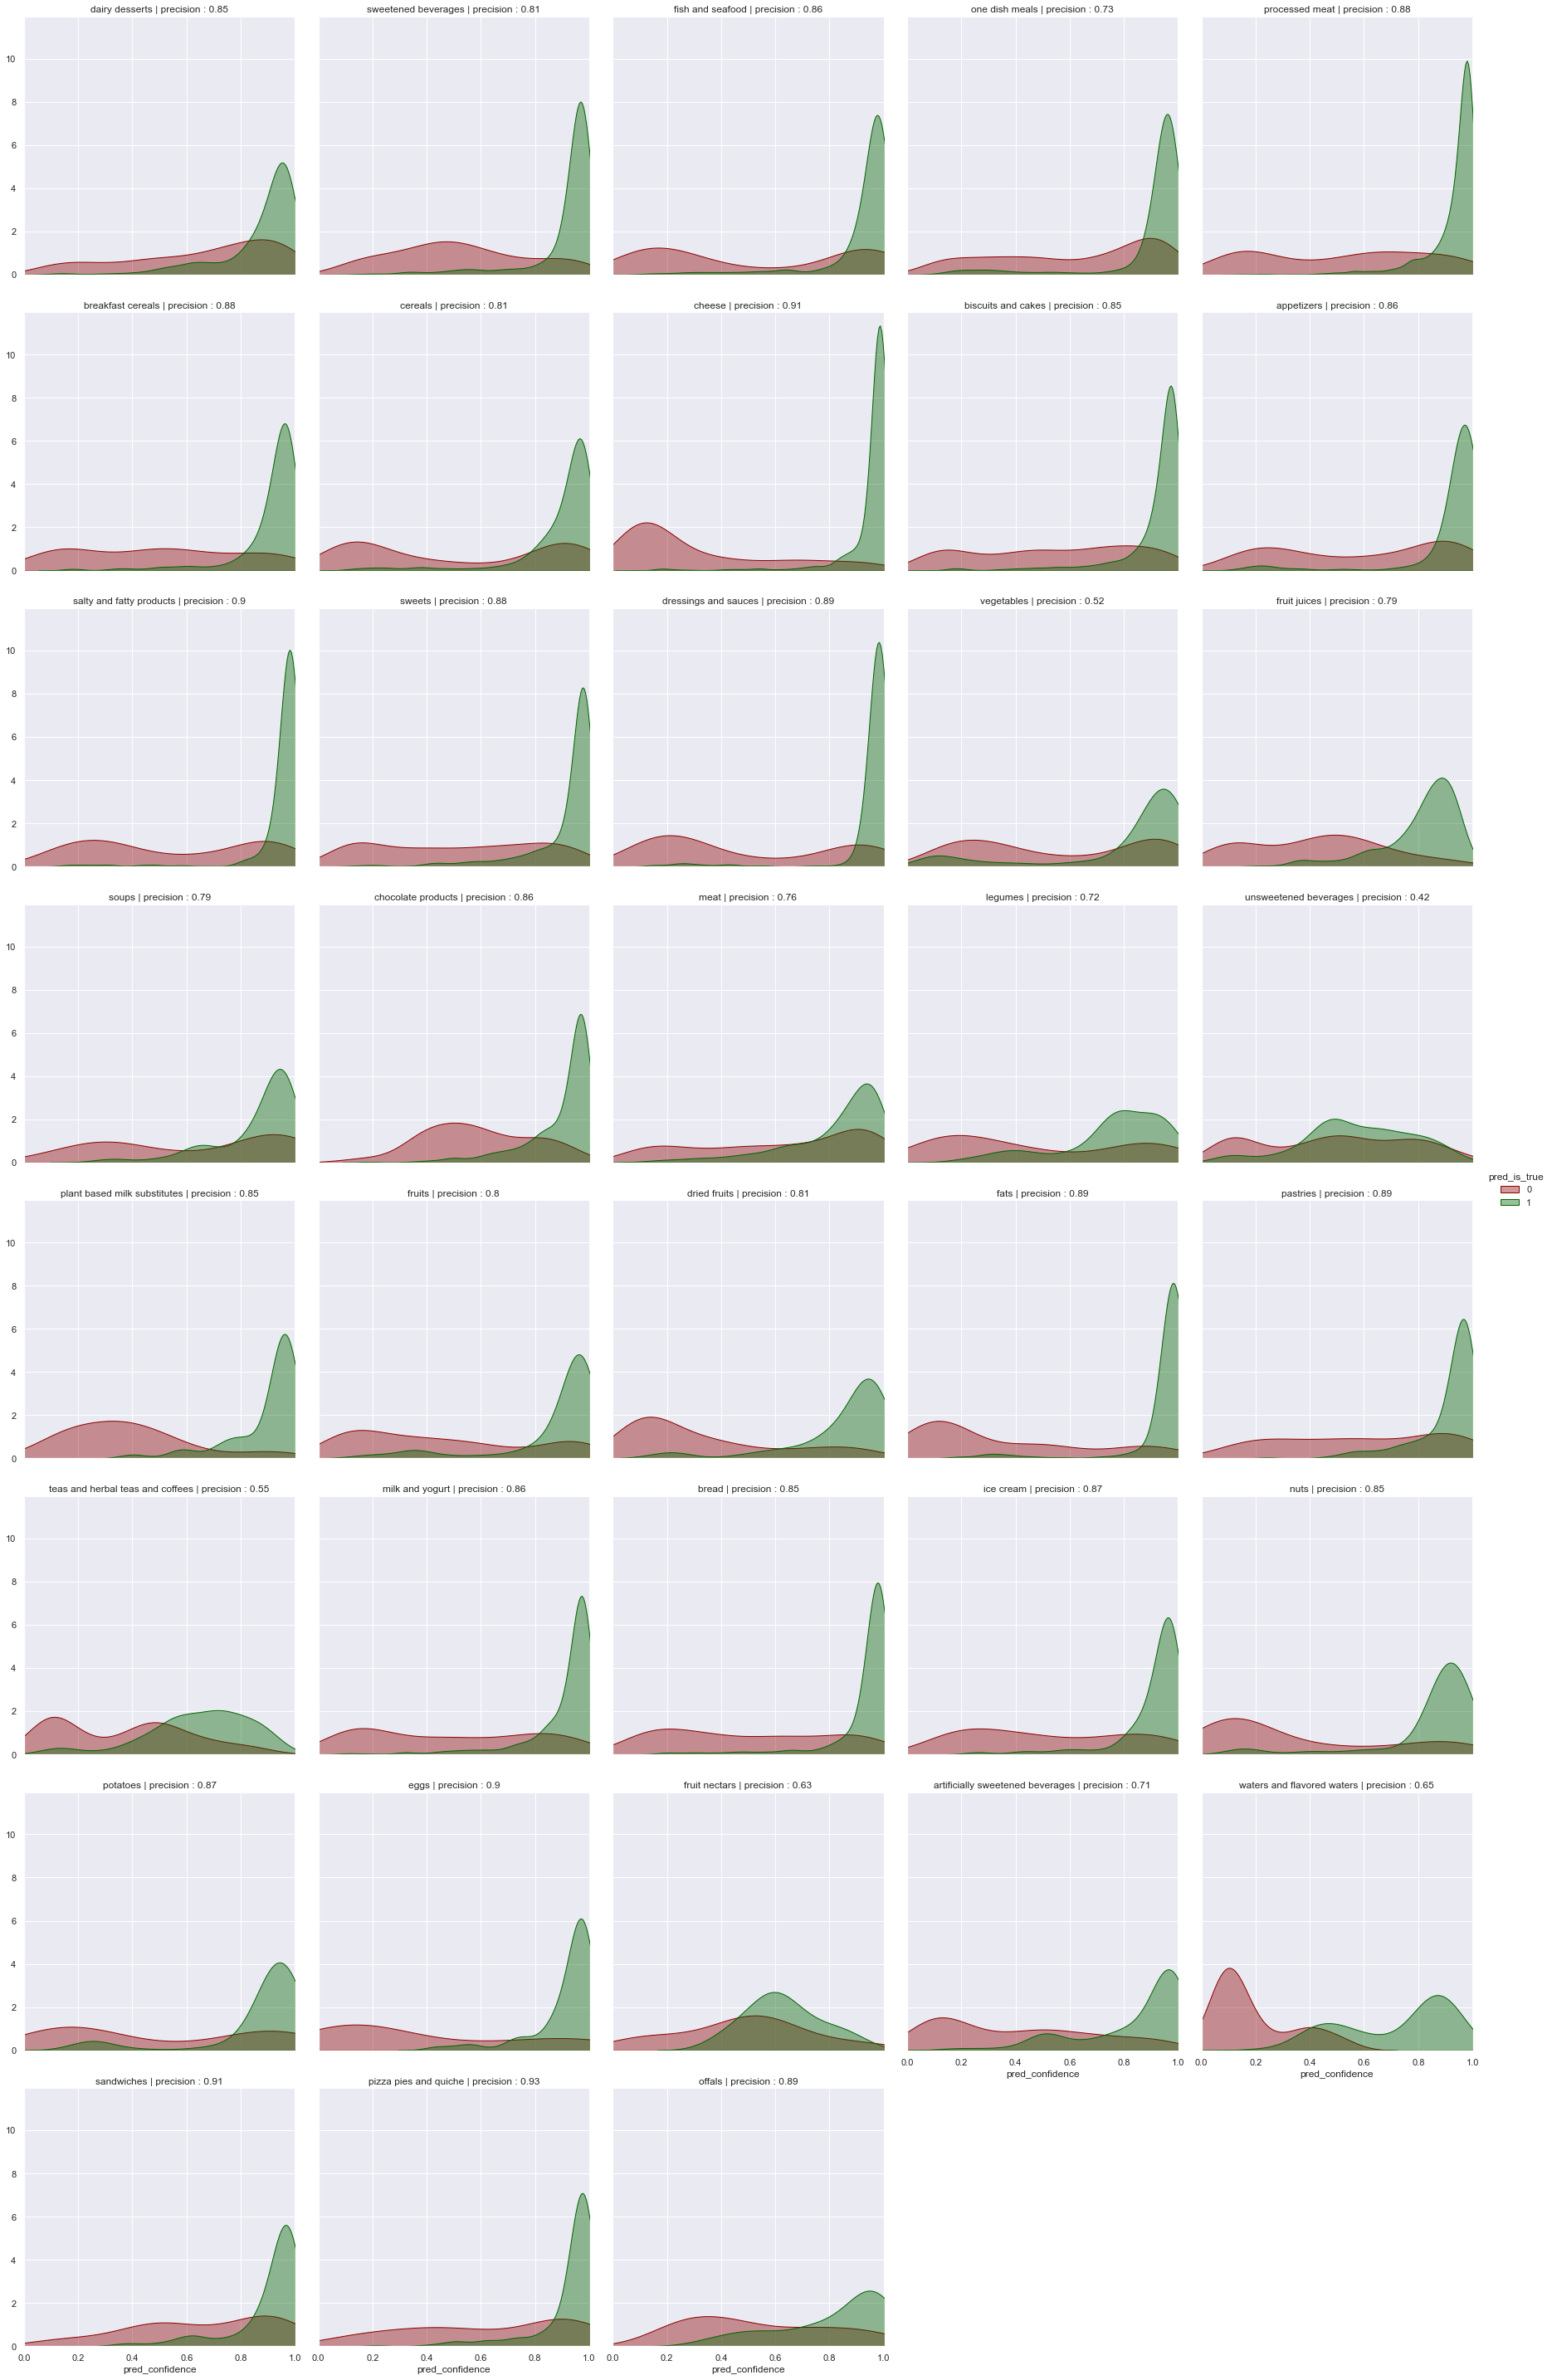

In [129]:
eval_G2_valid.plot_confidence()

## $Tresholds$ - $XGBoostG_2$ 

In [130]:
le_G2.classes_

array(['appetizers', 'artificially sweetened beverages',
       'biscuits and cakes', 'bread', 'breakfast cereals', 'cereals',
       'cheese', 'chocolate products', 'dairy desserts',
       'dressings and sauces', 'dried fruits', 'eggs', 'fats',
       'fish and seafood', 'fruit juices', 'fruit nectars', 'fruits',
       'ice cream', 'legumes', 'meat', 'milk and yogurt', 'nuts',
       'offals', 'one dish meals', 'pastries', 'pizza pies and quiche',
       'plant based milk substitutes', 'potatoes', 'processed meat',
       'salty and fatty products', 'sandwiches', 'soups',
       'sweetened beverages', 'sweets',
       'teas and herbal teas and coffees', 'unsweetened beverages',
       'vegetables', 'waters and flavored waters'], dtype=object)

In [166]:
tresh_G2 = {
    'appetizers':0.75, 
    'artificially sweetened beverages':0.65,
    'biscuits and cakes':0.75, 
    'bread':0.75, 
    'breakfast cereals':0.75, 
    'cereals':0.75,
    'cheese':0.8, 
    'chocolate products':0.55,
    'dairy desserts':0.55,
    'dressings and sauces':0.85, 
    'dried fruits':0.65, 
    'eggs':0.65, 
    'fats':0.75,
    'fish and seafood':0.75, 
    'fruit juices':0.65,
    'fruit nectars':0.7,
    'fruits':0.65,
    'ice cream':0.75, 
    'legumes':0.65, 
    'meat':0.75, 
    'milk and yogurt':0.75, 
    'nuts':0.75,
    'offals':0.55, 
    'one dish meals':0.88, 
    'pastries':0.65, 
    'pizza pies and quiche':0.55,
    'plant based milk substitutes':0.65, 
    'potatoes':0.7, 
    'processed meat':0.75,
    'salty and fatty products':0.75, 
    'sandwiches':0.65, 
    'soups':0.7,
    'sweetened beverages':0.7, 
    'sweets':0.6,
    'teas and herbal teas and coffees':0.8, 
    'unsweetened beverages':0.8,
    'vegetables':0.5, 
    'waters and flavored waters:':0.6
    }

In [167]:
tresh_G2_vals = np.array(list(tresh_G2.values()))

In [155]:
def filter_preds(y_true, y_probas, tresholds, unk_code=38):
  preds = []
  for p in y_probas:
    result = np.argwhere(p > tresholds)
    if result.size > 0: preds.append(int(result[0]))
    else : preds.append(unk_code)
    indices = np.array(np.where(np.array(preds) < unk_code)).flatten()
    y_true_keep = np.array(np.take(y_true, indices)).flatten()
    y_preds = np.take(np.array(preds), indices).flatten()
  return y_true_keep, y_preds

In [162]:
valid_true_G2, valid_pred_G2 = filter_preds(y_valid_G2, y_proba_G2_valid, tresh_G2_vals)

In [163]:
eval_tresh_G2 = Evaluator()
eval_tresh_G2.build_data(y_true=valid_true_G2, y_pred=valid_pred_G2, decode_labels=True,label_encoder=le_G2, pred_type='G2')

y_true               y_pred  pred_is_true
0           dairy desserts       dairy desserts             1
1      sweetened beverages   chocolate products             0
2         fish and seafood     fish and seafood             1
3           processed meat       processed meat             1
4        breakfast cereals    breakfast cereals             1
...                    ...                  ...           ...
22488       one dish meals       one dish meals             1
22489           vegetables           vegetables             1
22490               sweets               sweets             1
22491      milk and yogurt      milk and yogurt             1
22492  sweetened beverages  sweetened beverages             1

[22493 rows x 3 columns]

In [164]:
eval_tresh_G2.classification_report()

model_precision  model_recall  \
fruit nectars                                1.00          0.50   
sandwiches                                   0.97          0.88   
salty and fatty products                     0.96          0.93   
cheese                                       0.96          0.98   
fats                                         0.96          0.96   
dressings and sauces                         0.95          0.95   
pizza pies and quiche                        0.94          0.93   
milk and yogurt                              0.94          0.95   
appetizers                                   0.94          0.87   
fish and seafood                             0.94          0.92   
sweets                                       0.94          0.94   
pastries                                     0.93          0.87   
processed meat                               0.93          0.97   
breakfast cereals                            0.93          0.93   
offals                                       0.93          0.84   
plant based milk substitutes                 0.93          0.97   
ice cream                                    0.93          0.91   
biscuits and cakes                           0.92          0.94   
nuts                                         0.92          0.91   
cereals                                      0.92          0.90   
eggs                                         0.92          0.95   
artificially sweetened beverages             0.92          0.89   
weighted avg                                 0.92          0.92   
accuracy                                     0.92          0.92   
bread                                        0.92          0.93   
fruits                                       0.91          0.91   
macro avg                                    0.91          0.88   
sweetened beverages                          0.91          0.96   
meat                                         0.90          0.81   
dried fruits                                 0.89          0.89   
dairy desserts                               0.89          0.81   
chocolate products                           0.89          0.95   
potatoes                                     0.88          0.91   
vegetables                                   0.87          0.89   
waters and flavored waters                   0.87          1.00   
legumes                                      0.87          0.83   
fruit juices                                 0.86          0.98   
one dish meals                               0.84          0.86   
unsweetened beverages                        0.84          0.29   
soups                                        0.79          0.81   
teas and herbal teas and coffees             0.78          0.78   

                                  model_f1-score  model_support  
fruit nectars                               0.67           4.00  
sandwiches                                  0.92         175.00  
salty and fatty products                    0.95         731.00  
cheese                                      0.97        1204.00  
fats                                        0.96         504.00  
dressings and sauces                        0.95        1025.00  
pizza pies and quiche                       0.94         257.00  
milk and yogurt                             0.94        1047.00  
appetizers                                  0.91         542.00  
fish and seafood                            0.93         773.00  
sweets                                      0.94        2040.00  
pastries                                    0.90         247.00  
processed meat                              0.95        1272.00  
breakfast cereals                           0.93         384.00  
offals                                      0.88          49.00  
plant based milk substitutes                0.95         127.00  
ice cream                                   0.92         343.00  
biscuits and cakes             

In [165]:
6/28.5

0.21052631578947367

## $Evaluation$ $Test set$ - $XGBoostG_2$ - $without$ $tresholds$

In [ ]:
y_preds_G2_test = model_G2.predict(X_test_G2)
y_proba_G2_test = model_G2.predict_proba(X_test_G2)
y_conf_G2_test = get_confidences(y_preds_G2_test, y_proba_G2_test, unk_code=38)

In [169]:
eval_G2_test = Evaluator()
eval_G2_test.build_data(y_pred=y_preds_G2_test, y_true=y_test_G2, y_confidence=y_conf_G2_test, decode_labels=True,label_encoder=le_G2)

y_true                      y_pred  pred_is_true  \
0                          sweets                      sweets             1   
1      waters and flavored waters  waters and flavored waters             1   
2                          fruits       unsweetened beverages             0   
3                      sandwiches                  sandwiches             1   
4                       ice cream                   ice cream             1   
...                           ...                         ...           ...   
25128    salty and fatty products    salty and fatty products             1   
25129                      offals                        meat             0   
25130                      cheese                      cheese             1   
25131                  vegetables              one dish meals             0   
25132              one dish meals              one dish meals             1   

       pred_confidence  
0             0.941683  
1             0.480776  
2             0.448814  
3             0.538919  
4             0.693141  
...                ...  
25128         0.957950  
25129         0.667253  
25130         0.973210  
25131         0.839429  
25132         0.974569  

[25133 rows x 4 columns]

In [170]:
eval_G2_test.global_metrics()

Model Classification Metrics :
------------------------------
Accuracy : 80.35%
Recall : 80.35%
Precision : 81.18%
F1-score : 80.51%




In [171]:
eval_G2_test.classification_report()

model_precision  model_recall  \
offals                                       0.94          0.63   
cheese                                       0.93          0.89   
sandwiches                                   0.92          0.71   
pastries                                     0.92          0.77   
pizza pies and quiche                        0.92          0.85   
eggs                                         0.89          0.92   
salty and fatty products                     0.89          0.80   
fats                                         0.89          0.84   
processed meat                               0.89          0.91   
ice cream                                    0.88          0.85   
dressings and sauces                         0.88          0.88   
fish and seafood                             0.88          0.80   
sweets                                       0.87          0.85   
bread                                        0.87          0.81   
potatoes                                     0.86          0.75   
plant based milk substitutes                 0.86          0.84   
milk and yogurt                              0.85          0.86   
breakfast cereals                            0.85          0.75   
biscuits and cakes                           0.85          0.89   
chocolate products                           0.84          0.86   
sweetened beverages                          0.83          0.85   
appetizers                                   0.83          0.74   
dairy desserts                               0.83          0.68   
fruit juices                                 0.82          0.88   
weighted avg                                 0.81          0.80   
cereals                                      0.81          0.80   
macro avg                                    0.80          0.76   
accuracy                                     0.80          0.80   
soups                                        0.80          0.73   
nuts                                         0.79          0.71   
fruits                                       0.79          0.74   
dried fruits                                 0.76          0.61   
meat                                         0.74          0.69   
one dish meals                               0.72          0.77   
artificially sweetened beverages             0.72          0.68   
legumes                                      0.69          0.74   
fruit nectars                                0.67          0.19   
waters and flavored waters                   0.62          0.69   
teas and herbal teas and coffees             0.58          0.55   
vegetables                                   0.50          0.79   
unsweetened beverages                        0.42          0.40   

                                  model_f1-score  model_support  
offals                                      0.76           76.0  
cheese                                      0.91         1262.0  
sandwiches                                  0.81          207.0  
pastries                                    0.84          286.0  
pizza pies and quiche                       0.88          256.0  
eggs                                        0.91          119.0  
salty and fatty products                    0.84          746.0  
fats                                        0.86          539.0  
processed meat                              0.90         1255.0  
ice cream                                   0.87          381.0  
dressings and sauces                        0.88         1025.0  
fish and seafood                            0.84          814.0  
sweets                                      0.86         2097.0  
bread                                       0.84          601.0  
potatoes                                    0.80          176.0  
plant based milk substitutes                0.85          140.0  
milk and yogurt                             0.85         1081.0  
breakfast cereals              

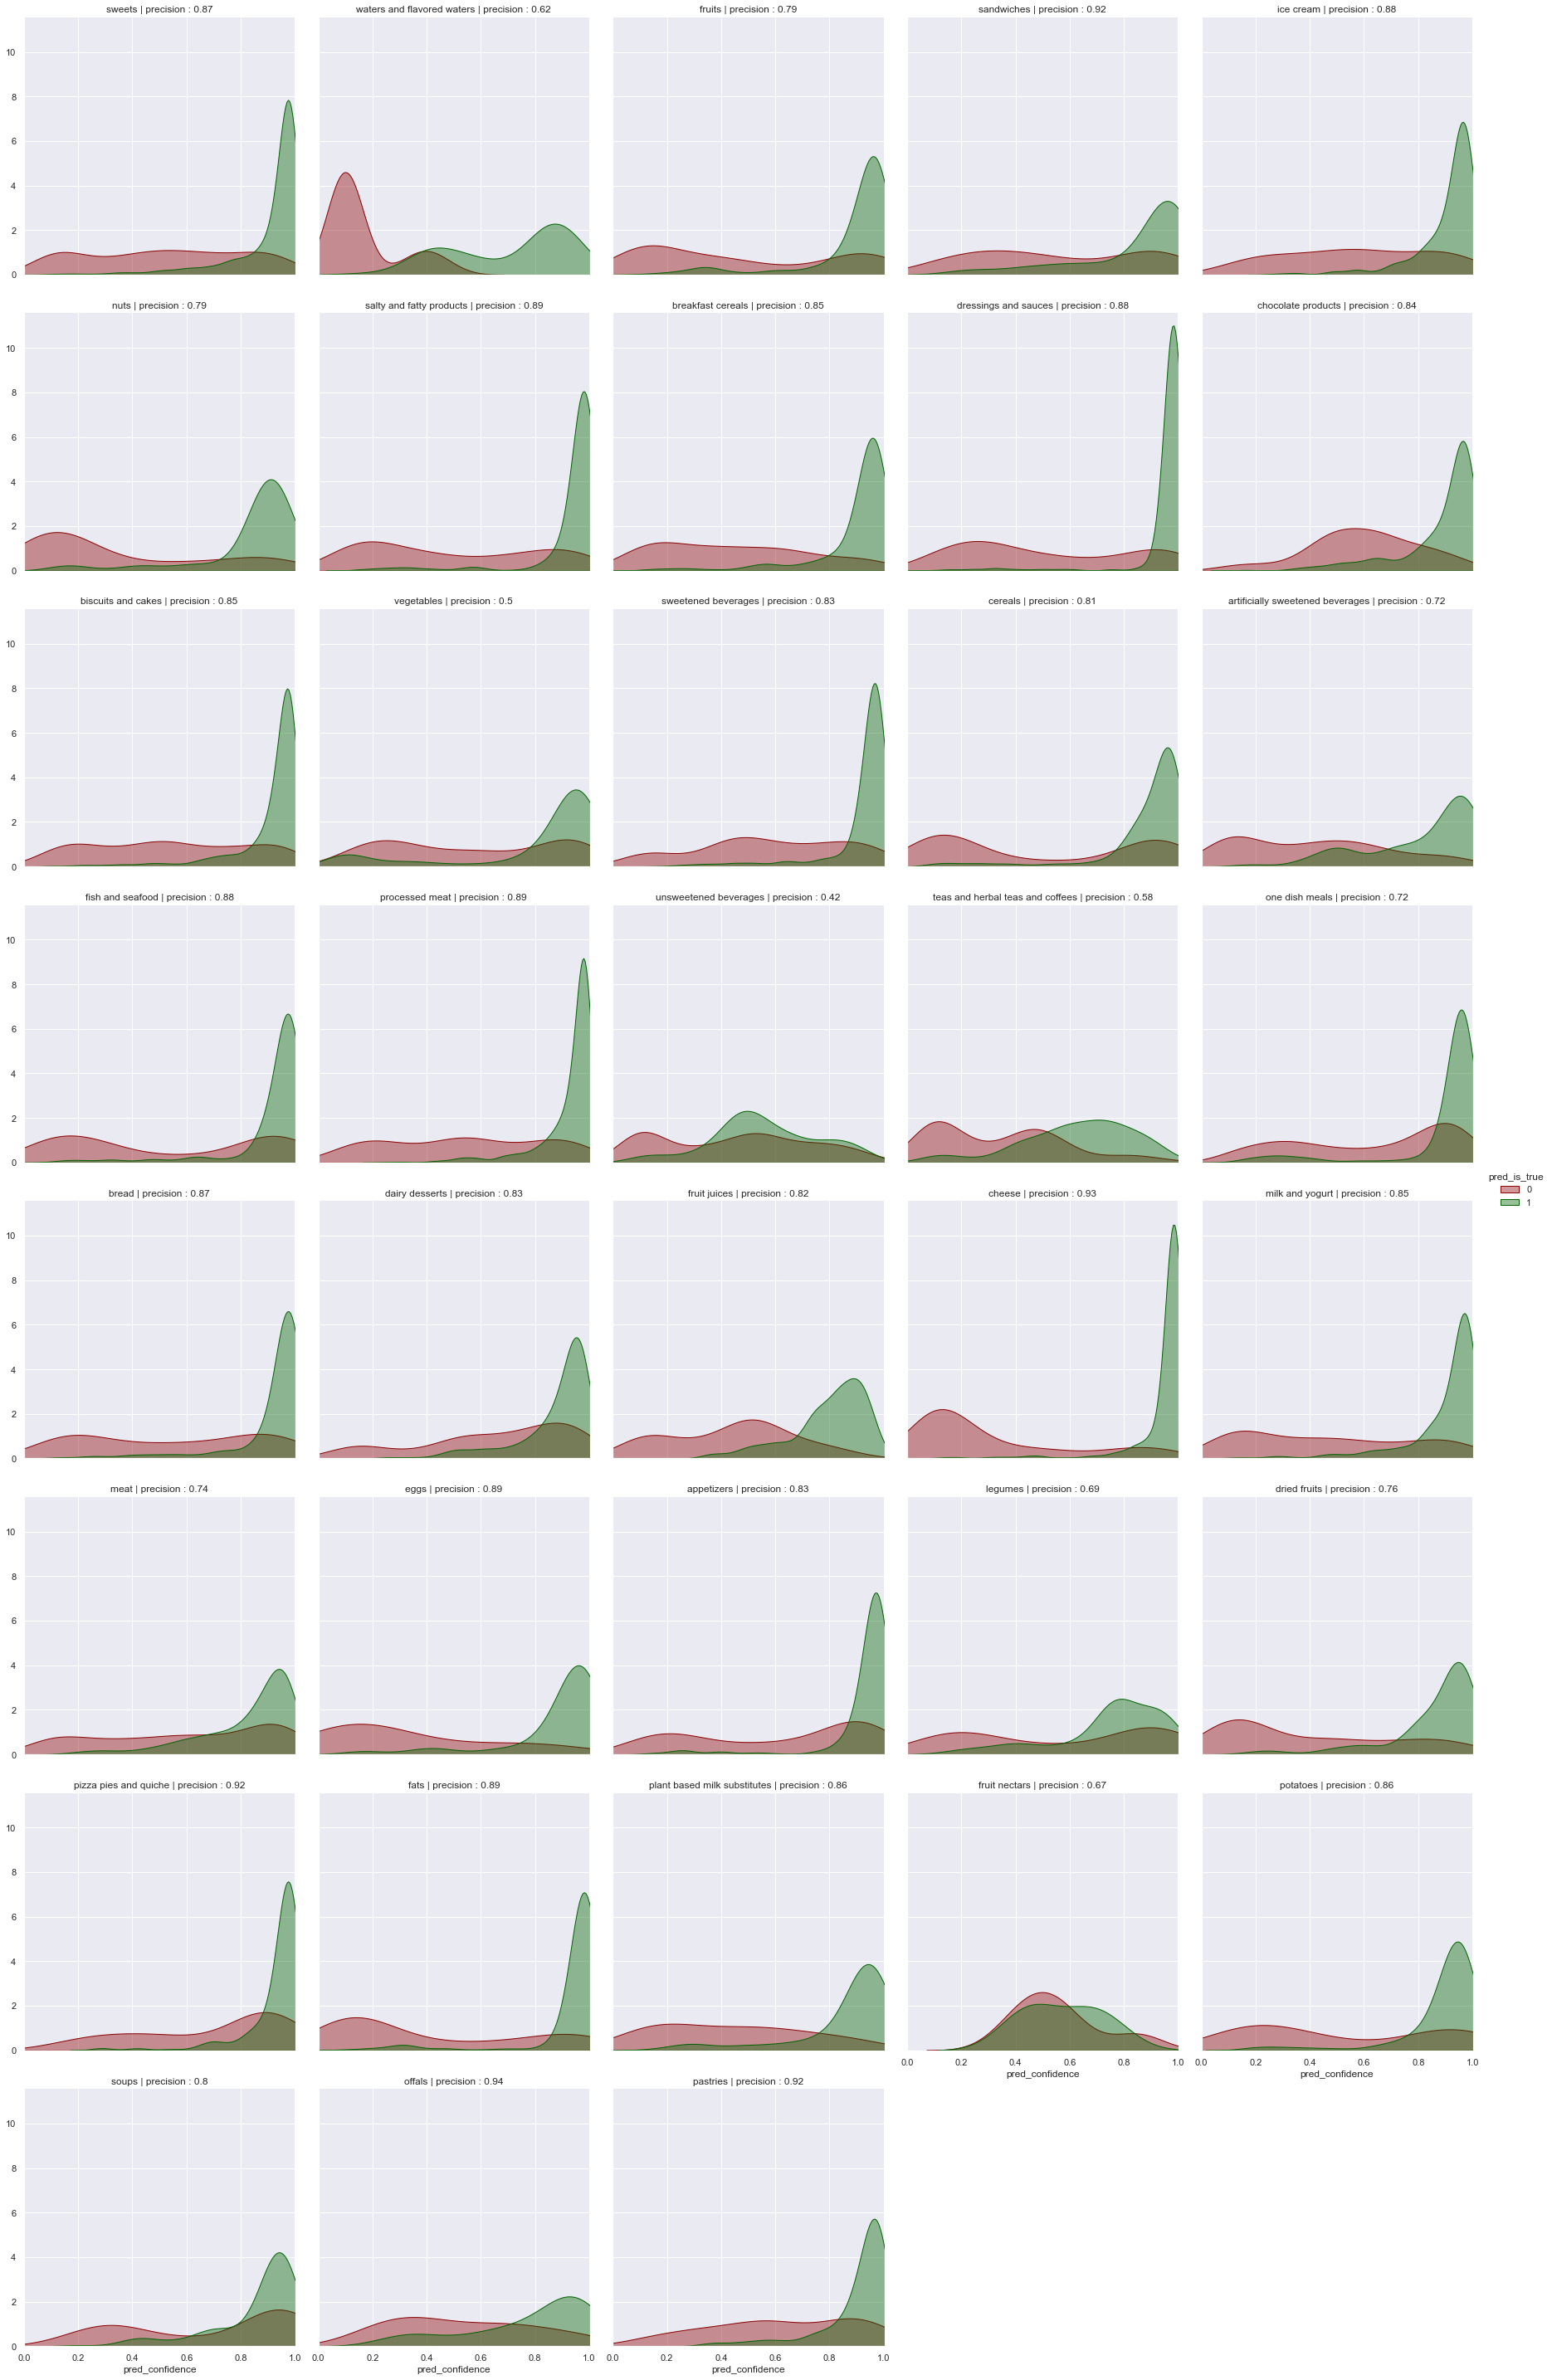

In [172]:
eval_G2_test.plot_confidence()

## $Evaluation$ $Test set$ - $XGBoostG_2$ - $tresholds = 0.4-0.8$

In [174]:
test_true_G2, test_pred_G2 = filter_preds(y_test_G2, y_proba_G2_test, tresh_G2_vals)
eval_tresh_G2 = Evaluator()
eval_tresh_G2.build_data(y_true=test_true_G2, y_pred=test_pred_G2, decode_labels=True,label_encoder=le_G2, pred_type='G2')

y_true                    y_pred  pred_is_true
0                        sweets                    sweets             1
1                          nuts                      nuts             1
2      salty and fatty products  salty and fatty products             1
3             breakfast cereals         breakfast cereals             1
4          dressings and sauces      dressings and sauces             1
...                         ...                       ...           ...
19559                    sweets                    sweets             1
19560  salty and fatty products  salty and fatty products             1
19561  salty and fatty products  salty and fatty products             1
19562                    cheese                    cheese             1
19563            one dish meals            one dish meals             1

[19564 rows x 3 columns]

In [182]:
#Nb preds drop
print(f'Number of predictions dropped : {((25-19.5)/25)*100}%')

Number of predictions dropped : 22.0%


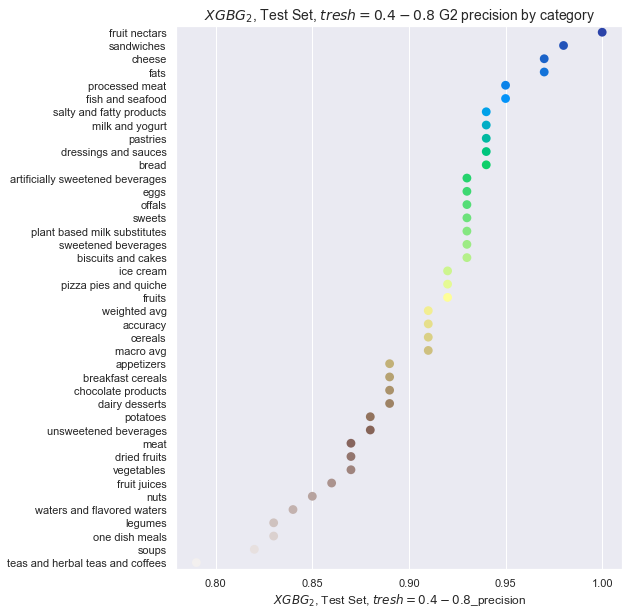

In [177]:
eval_tresh_G2.plot_categories_scores(name=r'$XGB$$G_2$, Test Set, $tresh = 0.4-0.8$')